# Bayes factor could be misleading

There are a lot of literature trying to draw conclusion from Bayes factor, but majority of them may not realize the subtleties in it.
### This notebook aims at pointing one problem - the choice of prior

In [125]:
# Importing relevant packages
%matplotlib inline
import dynesty
import numpy as np
from dynesty import plotting as dyplot
import matplotlib.pyplot as plt

Bayes factor is the evidence ratio between two models
$$
\ln{B} = \ln{\frac{Z_1}{Z_2}} = \ln{Z_1}-\ln{Z_2},
$$
and Bayes factor is often used to claim the data favour one hypothesis over another. The larger the Bayes factor the more data favour hypothesis 1 over hypothesis 2.

So how exactly is the evidence calculated? It is the normalization factor in Bayes theorem, which means you can compute it through integrating the product of the likelihood and prior you are sampling

$$
Z = \int d\theta\ p(d|\theta,\mathcal{H}) p(\theta|\mathcal{H}),
$$

and this is often done with nested sampling.

Here is an example computing the evidence for fitting a Gaussian

Text(0, 0.5, '$p(x)$')

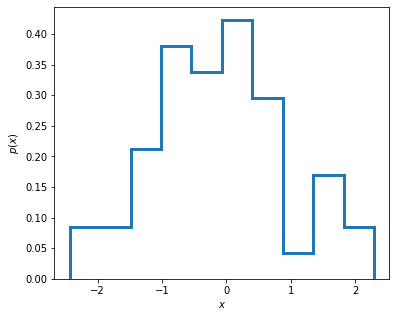

In [142]:
# Generating data from a Gaussian distribution centers at 0 and has sd=1
np.random.seed(2)
N_event = 50
data = np.random.normal(0,1,size=N_event)

# The log-likelihood is summing over all the idd data points
def log_like(x):
    return np.sum(-((data-x[0])/x[1])**2/2-np.log(x[1]*np.sqrt(2*np.pi)))

# A prior which covers the range we expect, mu in [-5,5], sigma in [0,3]
def prior(u):
    u[0] = (2*u[0]-1)*5
    u[1] = u[1]*3
    return u

# Visualizing the data
fig = plt.figure(figsize=(6,5))
plt.hist(data,histtype='step',lw=3,density=True)
plt.xlabel(r'$x$')
plt.ylabel(r'$p(x)$')

3238it [00:01, 2414.85it/s, +500 | bound: 4 | nc: 1 | ncall: 20713 | eff(%): 18.047 | loglstar:   -inf < -72.940 <    inf | logz: -78.573 +/-  0.138 | dlogz:  0.001 >  0.509]


The cumulative log evidence at the end of the sampling is : -78.5727382288416


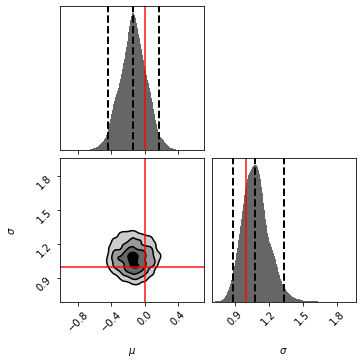

In [145]:
#Sampling the posterior, plotting the result and showing the evidence
sampler = dynesty.NestedSampler(log_like, prior, 2)
sampler.run_nested()
sresults = sampler.results
rfig, raxes = dyplot.cornerplot(sresults,truths=[0,1],labels=[r'$\mu$',r'$\sigma$'])
print('The cumulative log evidence at the end of the sampling is : '+str(sresults.logz[-1]))

Looks alright. The sampling recovers the true value within some confidence interval, and we have the evidence computed for us as well.

Now you may think we are done here.

# No

Let see what happens when we choose a different prior, say a super wide prior, as long as the prior contains the true value, it should be alright, right?

# No

8760it [00:03, 2880.28it/s, +500 | bound: 20 | nc: 1 | ncall: 32595 | eff(%): 28.409 | loglstar:   -inf < -76.862 <    inf | logz: -93.530 +/-  0.251 | dlogz:  0.001 >  0.509]


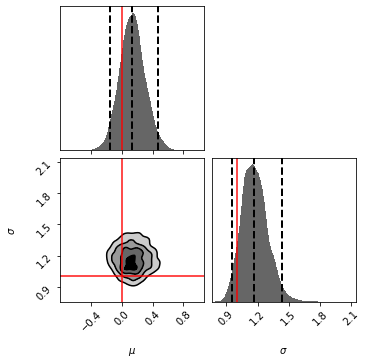

In [138]:
def super_wide_prior(u):
    u[0] = (2*u[0]-1)*1000
    u[1] = u[1]*1000
    return u

super_wide_sampler = dynesty.NestedSampler(log_like, super_wide_prior, 2)
super_wide_sampler.run_nested()
super_wide_sresults = super_wide_sampler.results
rfig, raxes = dyplot.cornerplot(super_wide_sresults,truths=[0,1],labels=[r'$\mu$',r'$\sigma$'])

See, Kaze? I told you you don't have to paranoid about using a different prior, the posterior recovered is exactly the same as using a narrow prior.

Huh, not until you check the evidence and the Bayes factor

In [144]:
print('The cumulative log evidence at the end of the sampling is : '+str(super_wide_sresults.logz[-1]))
print('The log Bayes factor of normal prior vs super wide prior is : '+str(sresults.logz[-1]-super_wide_sresults.logz[-1]))

The cumulative log evidence at the end of the sampling is : -93.52989095217748
The log Bayes factor of normal prior vs super wide prior is : 11.103006982937032


ln Bayes factor 11! If we look at the Jeffrey's scale this is super duper decisive evidence! Congrat you find dark energy, trying to publish in Natrue astronomy, they accept it, then a month later you are left confused finding everyone calling you a crackpot, why is this the case?

The thing is, you can keep changing the prior and get whatever Bayes factor you want out of the data, even the likelihood and data used in both cases are exactly the same. Let's look at how Bayes factor is computed in more detail.

$$
\ln{B} = \ln{\frac{Z_1}{Z_2}} = \ln{\frac{\int d\theta\ p(d|\theta,\mathcal{H}_{1}) p(\theta|\mathcal{H}_{1})}{\int d\theta\ p(d|\theta,\mathcal{H}_{2}) p(\theta|\mathcal{H}_{2})}},
$$

where $\mathcal{H}_1$ and $\mathcal{H}_2$ denote the two hypotheses which lead to the two different priors.

We can see even the likelihood is exactly the same, the prior value will drop if you choose a uniform prior (so it is a constant which you can pull out from the integral) and extend the range, meaning your Bayes factor is solely determined based on the ratio between the priors you chose.

So without properly characterizing the effect of prior with an injection campaign (there are other subtleties I omit here for simplicity.), the Bayes factor is meaningless at best. If Bayes factor is close to 1, then saying no significant conclusion can be drawn is probably a fair statement. If Bayes factor is hinting the data prefer one hypothesis over another, one should characterize the behaviour of that Bayes factor carefully.

# The bottom line is: we don't know how meaningful a generic Bayes factor is.

One can see why this is even more problematic for population analysis than normal parameter estimation. In a typical gravitational wave PE, the prior used are all on the source parameters, i.e. masses, spins, etc. As long as those priors are the same, at least this problem is gone. (Again, there are other subtleties.) Now let's look at comparison of two example populations:

$$
\ln{B} = \ln{\frac{Z_{\rm PBH}}{Z_{\rm phenom}}} = \ln{\frac{\int df_{pbh}\ p(d|f_{pbh},\mathcal{H}_{\rm PBH}) p(f_{\rm pbh}|\mathcal{H}_{\rm PBH})}{\int d\alpha\ p(d|\alpha,\mathcal{H}_{\rm phenom}) p(\alpha|\mathcal{H}_{\rm phenom})}}.
$$

For simplicity I use the fraction of dark matter in PBH $f_{\rm pbh}$ and the primary mass spectral index $\alpha$ to represent the two different set of hyper-parameters in the two model, of course you can extend this to more variables.

The likelihoods are certainly different, and the priors are also different. Without characterzing the behaviour of the Bayes factor, this number is literally meanless.

One of the most important but often forgotten aspect of Bayesian analysis is the prior, if you are not careful about the prior, you are almost certainly running into some pitfalls. Especially gravitational wave data is often noise dominated, prior is going to play a big role, so

# Don't forget your prior!
